In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


**Import Data**

In [2]:
df=pd.read_csv('blood_donation_dataset/training.csv', index_col='id')
print(df.shape)
df.describe()

(576, 5)


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


**Start Visualizing**

Box Plots of our key metrics

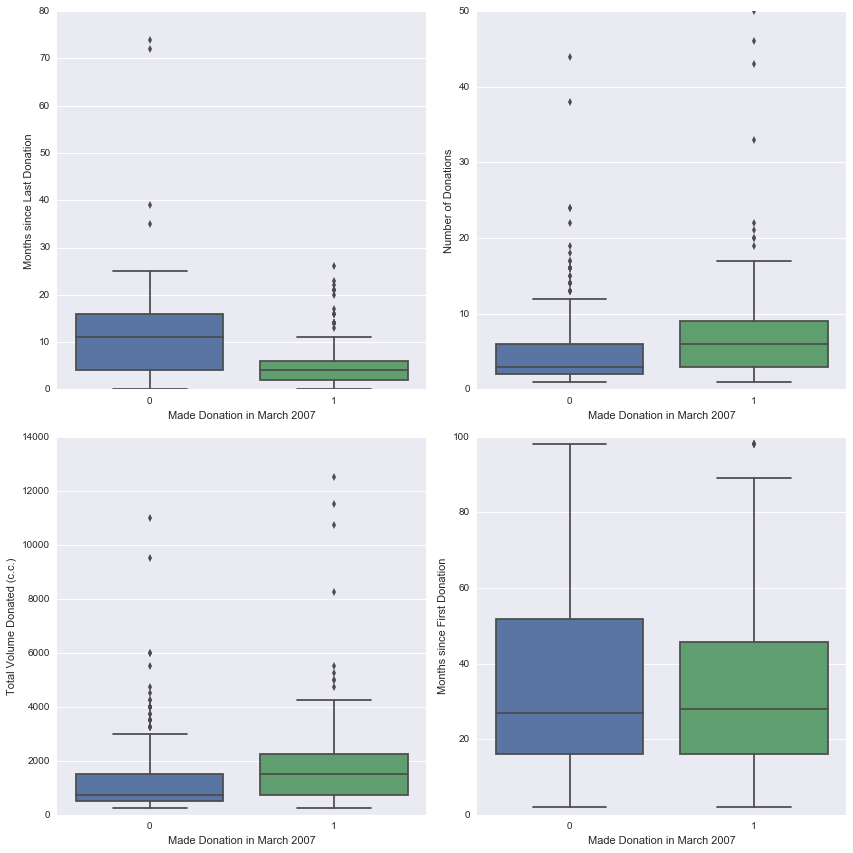

In [3]:
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.boxplot('Made Donation in March 2007', 'Months since Last Donation', data=df, orient='v', ax=ax1)
sns.boxplot('Made Donation in March 2007', 'Number of Donations', data=df, orient='v', ax=ax2)
sns.boxplot('Made Donation in March 2007', 'Total Volume Donated (c.c.)', data=df, orient='v', ax=ax3)
sns.boxplot('Made Donation in March 2007', 'Months since First Donation', data=df, orient='v', ax=ax4)
plt.tight_layout()

Mean of Months since last donations is signicanatly lower for users who donated in march than those who didn't. Volume and number of times is higher for users who donated in march and month's since first donation is similar for people who did and did not donate in march. Note that there are lots of outliers for each  metric except month's since first donation

Investigate correlation

In [4]:
df.corr()


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
Months since Last Donation,1.000000,-0.159731,-0.159731,0.186899,-0.261234
Number of Donations,-0.159731,1.000000,1.000000,0.622116,0.220615
Total Volume Donated (c.c.),-0.159731,1.000000,1.000000,0.622116,0.220615
Months since First Donation,0.186899,0.622116,0.622116,1.000000,-0.019819
Made Donation in March 2007,-0.261234,0.220615,0.220615,-0.019819,1.000000


Looking at the correlations between our predictors and response (made donation in  march), it looks like
people that haven't given in a while are less likely to donate. Further, people that have given a lot are more likely to donate, and first donation date doesn't matter much. It also looke like number and volume is perfectly correlation which makes sense (each time is probably a standard amount)

Correlation in this dataset does not imply causation because there are likely confounding variables not included in our model. For example, a person might be more likely to give if they have an in demand blood type, have had a family
member saved by blodd donation, or are younger. 

**Data Munging**

In [5]:
#outliers
print(df[abs(df - np.mean(df)) > 2 * np.std(df)].count())
print(df.count())
#e.g. 4% of our people had a number of donations that are outliers

Months since Last Donation      5
Number of Donations            20
Total Volume Donated (c.c.)    20
Months since First Donation    30
Made Donation in March 2007     0
dtype: int64
Months since Last Donation     576
Number of Donations            576
Total Volume Donated (c.c.)    576
Months since First Donation    576
Made Donation in March 2007    576
dtype: int64


In [6]:
#no missing values
df.isnull().values.any()

False

In [7]:
#Looking at linear regression below and correlation matrix above number and volume of donations are perfectly correlated
#we should remove one of the highly correlated variables from our model

Data Distribution

/Users/tom/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


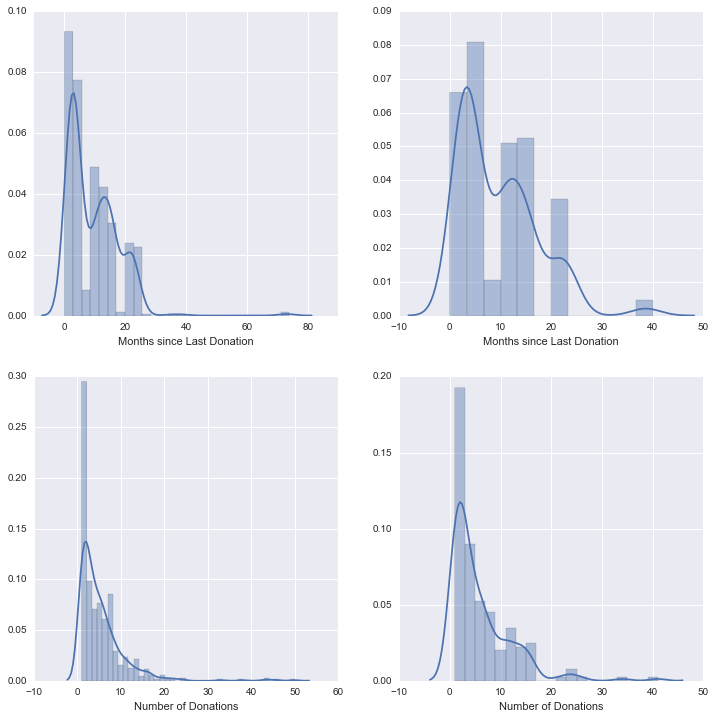

In [8]:
df2=pd.read_csv('blood_donation_dataset/test.csv', index_col='id')
ex1 = df['Months since Last Donation']
ex1_test = df2['Months since Last Donation']
ex2 = df['Number of Donations']
ex2_test = df2['Number of Donations']


fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
sns.distplot(ex1)

ax2 = plt.subplot(222)
sns.distplot(ex1_test)

ax3 = plt.subplot(223)
sns.distplot(ex2)

ax4 = plt.subplot(224)
sns.distplot(ex2_test)

#data is not normally distributed (skews to the right) but does seem similar in train and test

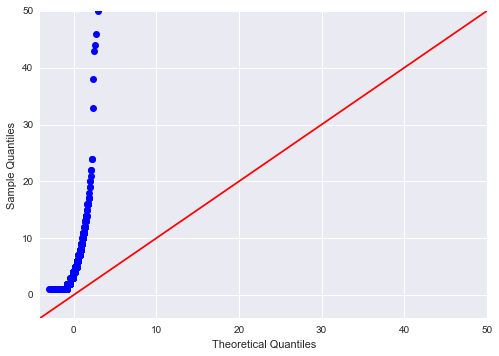

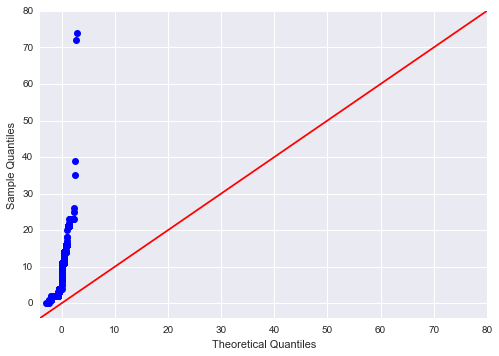

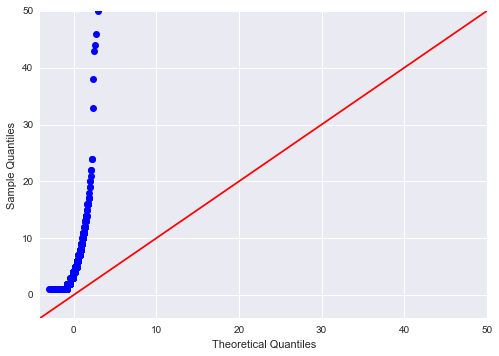

In [9]:
#QQ plot
sm.qqplot(ex1, line='45')

sm.qqplot(ex2, line='45')
#neither plot is normall distributed
# we coul potentially take the log of this data as there are a few large outliers

**Linear Modeling**

In [10]:
y = df[['Made Donation in March 2007']]
X = df[['Months since Last Donation', 'Number of Donations', 'Total Volume Donated (c.c.)', 'Months since First Donation']]
X = sm.add_constant(X)

clf = smf.OLS(y,X)
res = clf.fit()
print(res.summary())

#Assumptions: 
#Made donation in 2007 is a function of Recency of Donation and quantity of donations

                                 OLS Regression Results                                
Dep. Variable:     Made Donation in March 2007   R-squared:                       0.117
Model:                                     OLS   Adj. R-squared:                  0.112
Method:                          Least Squares   F-statistic:                     25.17
Date:                         Wed, 20 Jul 2016   Prob (F-statistic):           2.61e-15
Time:                                 23:22:36   Log-Likelihood:                -291.20
No. Observations:                          576   AIC:                             590.4
Df Residuals:                              572   BIC:                             607.8
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------

The model seems statiscally significant but is not very predictive (low r squared)

Null Hypothesis: there is no relationship between donation in march and recency and quanity of donations

Alternative Hypotheses: there is a relationship between donation in march and the X variables. 

All of our coefficients are statistically significant, but the coefficient on months since donation are negative therefore more recent donators are more likely to donate in march. Further the amoutn of donation is positively related to donation in march so people who have donated more are more likely to donate in march

**Feature Engineering**

In [11]:
#remove volume of donation from our model, add a squar of our months since column and scale all four predictor variable
df['months_since_squared'] = df['Months since Last Donation']**2
X = df[['Months since Last Donation', 'Number of Donations', 'Months since First Donation', 'months_since_squared']]
X = StandardScaler().fit_transform(X)
X = sm.add_constant(X)

clf = smf.OLS(y,X)
res = clf.fit()
print(res.summary())
#our scaled model is slightly more predictive than our last model
#shoudl we interpret overall significant with our f statistic?

                                 OLS Regression Results                                
Dep. Variable:     Made Donation in March 2007   R-squared:                       0.128
Model:                                     OLS   Adj. R-squared:                  0.122
Method:                          Least Squares   F-statistic:                     21.01
Date:                         Wed, 20 Jul 2016   Prob (F-statistic):           3.57e-16
Time:                                 23:22:36   Log-Likelihood:                -287.38
No. Observations:                          576   AIC:                             584.8
Df Residuals:                              571   BIC:                             606.5
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------

In [24]:
y_hat = res.predict(X)
y_hat

array([ 0.41900352,  0.05512509,  0.34881533,  0.4271705 ,  0.25873919,
        0.19776219,  0.486992  ,  0.16143656,  0.2218159 ,  0.13574881,
        0.0210786 ,  0.23351114,  0.04676636,  0.28667354,  0.24134989,
        0.25289061,  0.34494752,  0.31909119,  0.04676636,  0.15376893,
       -0.03461949,  0.283503  , -0.05349021,  0.33341474,  0.22872711,
        0.26006192,  0.27926905,  0.08708315,  0.24703104,  0.72651009,
        0.51975657,  0.33245312,  0.08052817,  0.1886648 ,  0.2661044 ,
        0.34649504,  0.22397479,  0.52844347,  0.0516872 ,  0.327032  ,
        0.31159917,  0.01981686,  0.27851788,  0.31909119,  0.25698588,
        0.24179509, -0.03461949,  0.37030272, -0.03461949,  0.24179509,
        0.29093917,  0.34649504,  0.24179509,  0.05012017,  0.24896376,
        0.16205111,  0.11950704,  0.12932076,  0.09259738,  0.20442099,
        0.31086494,  0.08894997,  0.04622462,  0.24179509,  0.20442099,
        0.34198737,  0.3897964 ,  0.0210786 ,  0.24179509,  0.29

In [12]:
#remove volume of donation from our model, add a square of our months since column, a log of number of donation,and scale all four predictor variable
df['months_since_squared'] = df['Months since Last Donation']**2
df['number_log'] = np.log(df['Number of Donations'])
X = df[['Months since Last Donation', 'Number of Donations', 'Months since First Donation', 'months_since_squared', 'number_log']]
X = StandardScaler().fit_transform(X)
X = sm.add_constant(X)

clf = smf.OLS(y,X)
res = clf.fit()
print(res.summary())
#our scaled model is slightly more predictive than our last model
#shoudl we interpret overall significant with our f statistic?

                                 OLS Regression Results                                
Dep. Variable:     Made Donation in March 2007   R-squared:                       0.152
Model:                                     OLS   Adj. R-squared:                  0.145
Method:                          Least Squares   F-statistic:                     20.50
Date:                         Wed, 20 Jul 2016   Prob (F-statistic):           7.65e-19
Time:                                 23:22:36   Log-Likelihood:                -279.30
No. Observations:                          576   AIC:                             570.6
Df Residuals:                              570   BIC:                             596.7
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------

**Conclusion**

Our linear model is not a strong predictor of donation in march due to low explained variance, and the  high error values, but the coefficient signs on the predictor variables make sense. More donation leads to more likely to donate and more recent leads to more likely to donate

# Prediction

Use your best model to predict blood donations on the test dataset
Check that the results are coherent (visually or statistically)
Save the results in a csv file according to the BloodDonationSubmissionFormat.csv file. male sure the index / id are correct

In [28]:
#Running regression on test data with our linear model

df['months_since_squared'] = df['Months since Last Donation']**2
df['number_log'] = np.log(df['Number of Donations'])
X = df[['Months since Last Donation', 'Number of Donations', 'Months since First Donation', 'months_since_squared', 'number_log']]
SS = StandardScaler()
X = SS.fit_transform(X)
#want to scale  using the same parameters in the train and test
X = sm.add_constant(X)

clf = smf.OLS(y,X)
res = clf.fit()

df2=pd.read_csv('blood_donation_dataset/test.csv', index_col='id')
df2['months_since_squared'] = df2['Months since Last Donation']**2
df2['number_log'] = np.log(df2['Number of Donations'])
X_test = df2[['Months since Last Donation', 'Number of Donations', 'Months since First Donation', 'months_since_squared', 'number_log']].values
X_test = SS.fit_transform(X_test)
X_test = sm.add_constant(X_test)
y_hat = res.predict(X_test)

#score = mean_squared_error(y_test, y_hat)
#print(score)

In [29]:
np.mean(y_hat)

0.2395833333333334

In [32]:
y_hat = pd.DataFrame(y_hat)

In [33]:
y_hat.to_csv('blood_donation_dataset/restults.csv', sep='\t')